In [1]:
import os
import json
import evaluate
import numpy as np
from PIL import Image

/home/dhruv/anaconda3/envs/vila/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Set Up

In [3]:
dev_output = json.load(open('/home/dhruv/Projects/imSitu_Clip/VILA/vidsitu_output_top1_valid_update.json', 'r'))

In [4]:
len(dev_output)

1326

In [5]:
with open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_valid_lb.json', 'r') as f:
    valid = json.load(f)

In [12]:
test = json.load(open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_testsrl_noann_lb.json', 'r'))

In [15]:
def select_random_annotator(annotator_list):
    """
    Selects a random annotator from every 3 consecutive indices in the list.
    
    Args:
    annotator_list (list): List where every 3 indices correspond to the same video segment.
    
    Returns:
    list: Final list with one annotator per segment.
    """
    final_list = []
    
    for i in range(0, len(annotator_list), 3):
        segment = annotator_list[i:i+3]
        selected_annotator = random.choice(segment)
        final_list.append(selected_annotator)
    
    return final_list

#valid_random_GT = select_random_annotator(valid)
test_random_GT = select_random_annotator(test)

In [13]:
with open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vidsitu_valid_subset_GT.json', 'r') as f:
    valid_random_GT = json.load(f)

In [19]:
with open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/split_files/vseg_split_valid_lb.json', 'r') as f:
    val_split = json.load(f)

In [3]:
with open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_train_lb.json', 'r') as f:
    train = json.load(f)

In [16]:
valid_set = set([event['vid_seg_int'] for x in valid for event in x.values()])

In [95]:
train_set = set([event['vid_seg_int'] for x in train for event in x.values()])

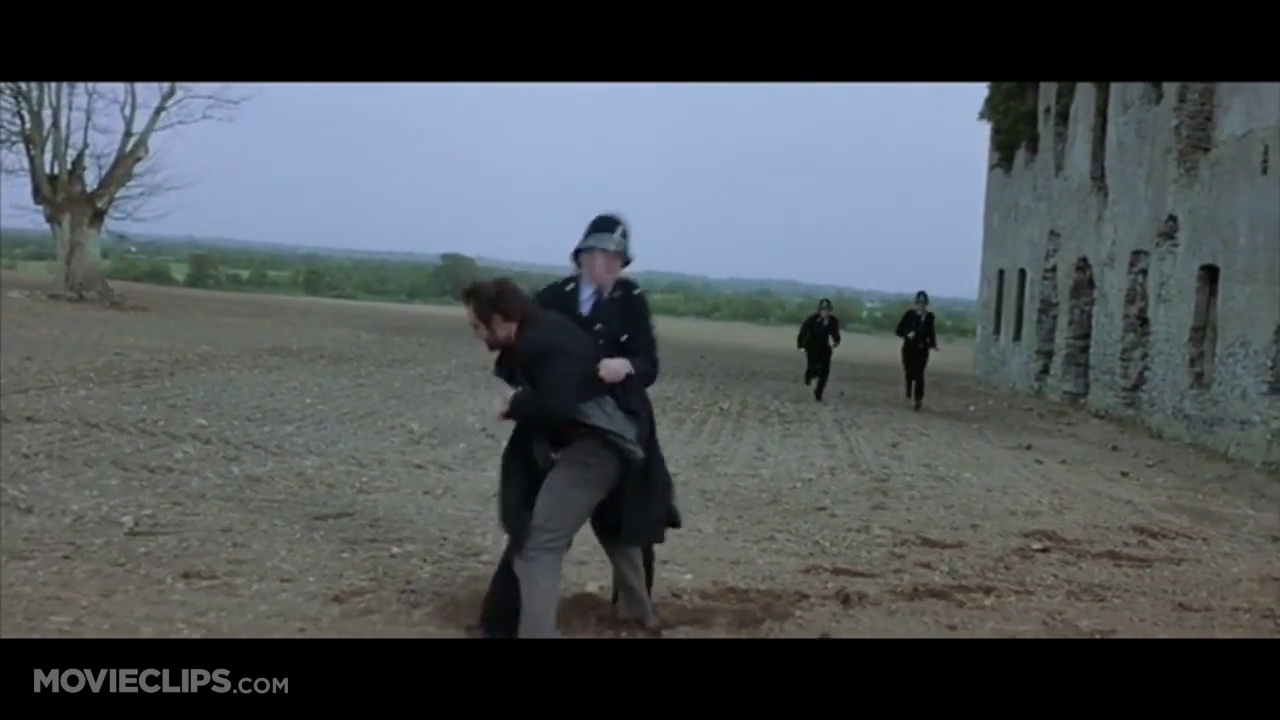

In [4]:
img = '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_rtqgJvhrswY_seg_80_90/frame_07.jpg'
Image.open(img)

In [166]:
for i in train:
    for event, val in i.items():
        if val['vid_seg_int'] == 'v_VYQoxBs5N2A_seg_90_100':
            print(val)

In [170]:
train[1023]['Ev4']

{'vid_uid': 'rtqgJvhrswY5',
 'vid_seg_int': 'v_rtqgJvhrswY_seg_80_90',
 'EvRel': 'Causes',
 'Args': {'Arg0 (entity grappling)': 'running man in long black coat',
  'Arg1 (grappling with what)': 'police',
  'Scene of the Event': 'ruins of castle'},
 'Arg_List': {'Arg0 (entity grappling)': '0',
  'Arg1 (grappling with what)': '1',
  'Scene of the Event': '2'},
 'Verb': 'grapple (deal with)',
 'VerbID': 'grapple.01'}

## Main VidSitu VILA

In [175]:
import subprocess

vidsitu_visual_prompt = """
Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. Specifically, describe the action (verb). Then, fill the nouns playing the roles "Arg0", "Arg1", "Arg2", "Scene of the Event" in the verb (action).
JSON Response Format Template: {{
    "Verb": "{verb}",
    "Args": {{
        {roles_json}
    }}
}}

In-Context Example for Guidance:
<image> {{
  "Verb": "point (point at, define, make an example of)", 
  "Args": {{
    'Arg0 (pointer)': ['girl in the green striped shirt'],
    'Arg1 (pointed at)': [''],
    'ArgM (direction)': ['off in the distance'],
    'Scene of the Event': ['spacious coffee shop']
  }}
}}
<image> {{
  "Verb": "reach (stretch, grasp)",
  "Args": {{
    'Arg0 (reacher)': ['dark-haired woman with coiffed hairstyle and black strapless dress with a plunging neckline]',
    'Arg1 (body part)': ['both hands'],
    'Arg2 (goal)': ['to work on'],
    'ArgM (direction)': ['behind her back'],
    'ArgM (purpose)': ['undoing the back of her dress'],
    'Scene of the Event': ['bedroom']
  }}
}}
<image> {{
  "Verb": "kiss (smooch)", 
  "Args": {{
    'Arg0 (kisser)': ['the lady on the bed'],
    'Arg1 (kissed)': ['the man lying on the bed'],
    'ArgM (location)': ['in the room'],
    'ArgM (manner)': ['passionately']
  }}
}}
<image> {{
  "Verb": "grapple (deal with)",
  "Args": {{
    'Arg0 (entity grappling)': ['running man in long black coat'],
    'Arg1 (grappling with what)': ['police'],
    'Scene of the Event': ['ruins of castle']
  }}
}}

<image> {{
  "Verb": "choke (to have or cause to have  difficulty in breathing)",  
  "Args": {{
    "Arg0 (causer of choking, agent)": ["the man with the blonde hair"],
    "Arg1 (entity choked)": ["the man with the brown hair"],
    "Scene of the Event": ["on a bridge"]
  }}
}}


Do not give an explanation or any more unnecessary information other than the JSON format.
Now, based on the image <image>, provide a structured summary in the JSON format as instructed above.
"""


# with open("vidsitu_visual_prompt2.txt", "w") as f:
#     f.write(vidsitu_visual_prompt)

In [163]:
example_images

['/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_V-vgoh3ukPc_seg_95_105/frame_06.jpg',
 '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_Kz234-_khjs_seg_75_85/frame_09.jpg',
 '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_8wDlH8jWxYk_seg_5_15/frame_03.jpg',
 '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_09.jpg',
 '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_tSZtoveaa0A_seg_40_50/frame_01.jpg']

In [176]:
example_images = '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_V-vgoh3ukPc_seg_95_105/frame_06.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_Kz234-_khjs_seg_75_85/frame_09.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_8wDlH8jWxYk_seg_5_15/frame_03.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_rtqgJvhrswY_seg_80_90/frame_07.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_tSZtoveaa0A_seg_40_50/frame_01.jpg'
example_images = example_images.split(',')

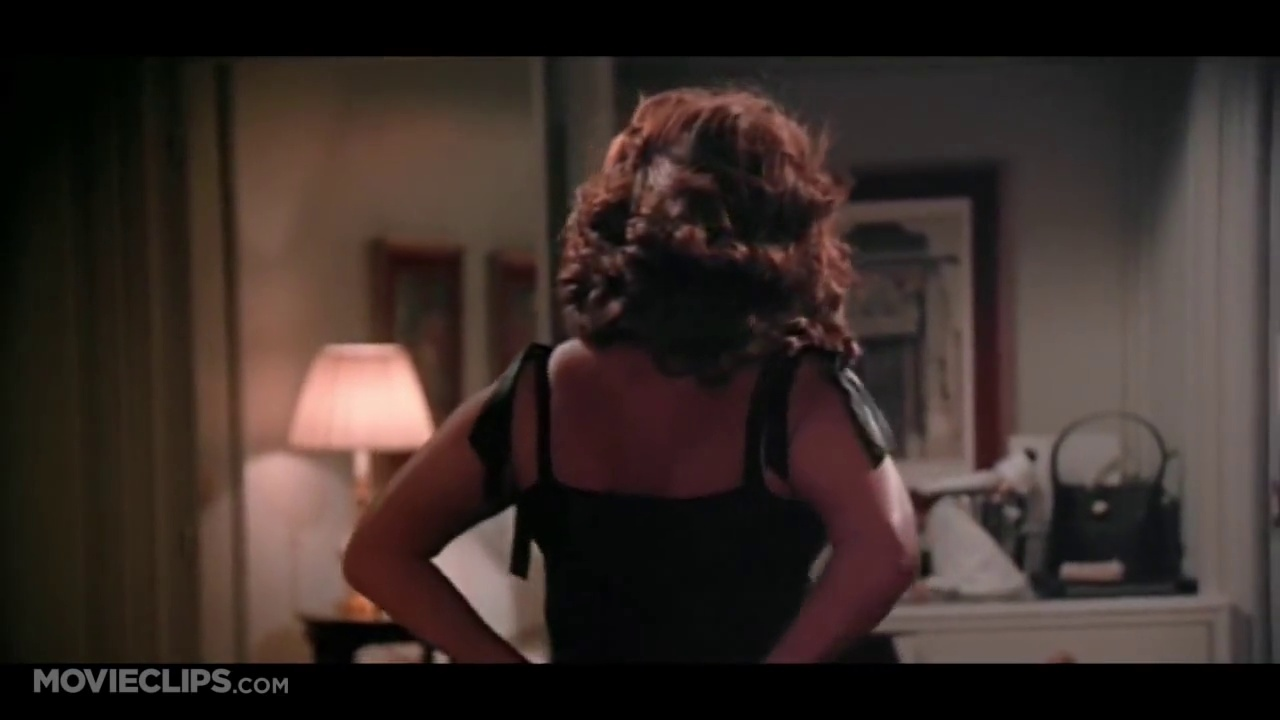

In [180]:
Image.open(example_images[1])

## Testing

In [7]:
def generate_prompt(vidsitu_visual_prompt, verb, roles, top_5):
    role_list = ["Arg0", "Arg1", "Arg2", "Scene of the Event"]
    
    # Filter roles based on role_list
    filtered_roles = [role for role in roles if any(role.startswith(r) for r in role_list)]

    if top_5:
        roles_json = ",\n    ".join([f'"{role}": ["", "", "", "", ""]' for role in filtered_roles])
    else:
        roles_json = ",\n    ".join([f'"{role}": [""]' for role in filtered_roles])

    return vidsitu_visual_prompt.format(verb=verb, roles_json=roles_json)

In [3]:
import argparse
import re
from io import BytesIO
import os, os.path as osp
import json
from tqdm import tqdm
import requests
import torch
from PIL import Image

from llava.constants import (DEFAULT_IM_END_TOKEN, DEFAULT_IM_START_TOKEN,
                             DEFAULT_IMAGE_TOKEN, IMAGE_PLACEHOLDER,
                             IMAGE_TOKEN_INDEX)
from llava.conversation import SeparatorStyle, conv_templates
from llava.mm_utils import (KeywordsStoppingCriteria, get_model_name_from_path,
                            process_images, tokenizer_image_token)
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
def image_parser(image_file, sep=","):
    return image_file.split(sep)


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        print("downloading image from url", image_file)
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

def eval_model(model, tokenizer, image_processor, args, images, prompt):
    qs = prompt
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in qs:
        if model.config.mm_use_im_start_end:
            qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
        else:
            qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
    else:
        if DEFAULT_IMAGE_TOKEN not in qs:
            print("no <image> tag found in input. Automatically append one at the beginning of text.")
            if model.config.mm_use_im_start_end:
                qs = (image_token_se + "\n") * len(images) + qs
            else:
                qs = (DEFAULT_IMAGE_TOKEN + "\n") * len(images) + qs

    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    images_tensor = process_images(images, image_processor, model.config).to(model.device, dtype=torch.float16)
    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).cuda()

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=[images_tensor],
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            max_new_tokens=args.max_new_tokens,
            use_cache=True,
            stopping_criteria=[stopping_criteria],
        )

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0]
    outputs = outputs.strip()
    if outputs.endswith(stop_str):
        outputs = outputs[: -len(stop_str)]
    outputs = outputs.strip()
    return outputs

/home/dhruv/anaconda3/envs/vila/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
parser = argparse.ArgumentParser()
parser.add_argument("--conv-mode", type=str, default=None)
parser.add_argument("--sep", type=str, default=",")
parser.add_argument("--temperature", type=float, default=0.2)
parser.add_argument("--top_p", type=float, default=None)
parser.add_argument("--num_beams", type=int, default=1)
parser.add_argument("--max_new_tokens", type=int, default=512)
args = parser.parse_args(['--conv-mode','llama_3','--sep', ';', '--temperature', '0.5', '--max_new_tokens', '1024']) 


disable_torch_init()
model_path = 'Efficient-Large-Model/Llama-3-VILA1.5-8b'
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(model_path, model_name, None)

image_dir = '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid'
example_images = '/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_02.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_03.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_05.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_09.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_tSZtoveaa0A_seg_40_50/frame_01.jpg'
example_images = image_parser(example_images, ",")

with open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vidsitu_valid_subset_GT.json', 'r') as f:
    valid = json.load(f)
for clip_info in valid[:1]:
    clip_name = clip_info["Ev1"]["vid_seg_int"]
    
    clip_results = {}
    for event_index, event_key in enumerate(["Ev1"]):
        event_info = clip_info[event_key]
        event_results = []

        if event_index == 0:
            frame_indices = range(3)
        else:
            frame_indices = range(3 + (event_index - 1) * 2, 3 + event_index * 2)
        
        for frame_index in frame_indices:
            verb = event_info["Verb"]
            roles = event_info['Args'].keys()
            frame_path = os.path.join(image_dir, f"{clip_name}", f"frame_{frame_index:02}.jpg")

            if not os.path.exists(frame_path):
                print("The clip frame dir does not exist.")
                continue
            prompt = generate_prompt(vidsitu_visual_prompt, verb, roles, False)

            # Combine example images with the current frame
            current_images = example_images + [frame_path]
            images = load_images(current_images)

            output = eval_model(model, tokenizer, image_processor, args, images, prompt)

/home/dhruv/anaconda3/envs/vila/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████| 4/4 [00:07<00:00,  1.81s/it]
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


NameError: name 'generate_prompt' is not defined

In [11]:
prompt = generate_prompt(vidsitu_visual_prompt, verb, roles, False)

current_images = example_images + [frame_path]
images = load_images(current_images)

output = eval_model(model, tokenizer, image_processor, args, images, prompt)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [12]:
output

'{\n"Verb": "drive (drive a vehicle)",\n"Args": {\n"Arg0 (driver)": [""],\n"Arg1 (vehicle or path)": [""],\n"Scene of the Event": [""]\n}\n}'

In [ ]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [104]:
verb

'drive (drive a vehicle)'

In [108]:
roles

dict_keys(['Arg0 (driver)', 'Arg1 (vehicle or path)', 'ArgM (direction)', 'ArgM (manner)', 'Scene of the Event'])

## Run VILA

In [89]:
image_files = "/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_02.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_03.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_05.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_09.jpg,/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_tSZtoveaa0A_seg_40_50/frame_01.jpg"

In [25]:
import os
dirs = os.listdir("/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100")

In [ ]:
import subprocess
command = [
    "python", "-W", "ignore", "./llava/eval/VILA_vidsitu.py",
    "--model-path", "Efficient-Large-Model/Llama-3-VILA1.5-8b",
    "--data_file", "/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_valid_lb.json",
    "--image_dir", "/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid",
    "--output_file", "vidsitu_output_top1_dev.json",
    "--vidsitu_visual_prompt_file", "vidsitu_visual_prompt.txt",
    "--example_images", image_files,
    "--conv-mode", "llama_3",
    #"--top_5"  # Include this flag to generate top 5 nouns
]

# Run the command
subprocess.run(command)

In [85]:
vids = []
for i in valid:
    for event, val in i.items():
        vids.append(val["vid_seg_int"])

In [86]:
len(set(vids))

1326

In [89]:
'v_VYQoxBs5N2A_seg_120_130' in set(vids)

True

In [32]:
713 * 5

3565

In [37]:
train[0]['Ev1']['vid_uid']

'VYQoxBs5N2A1'

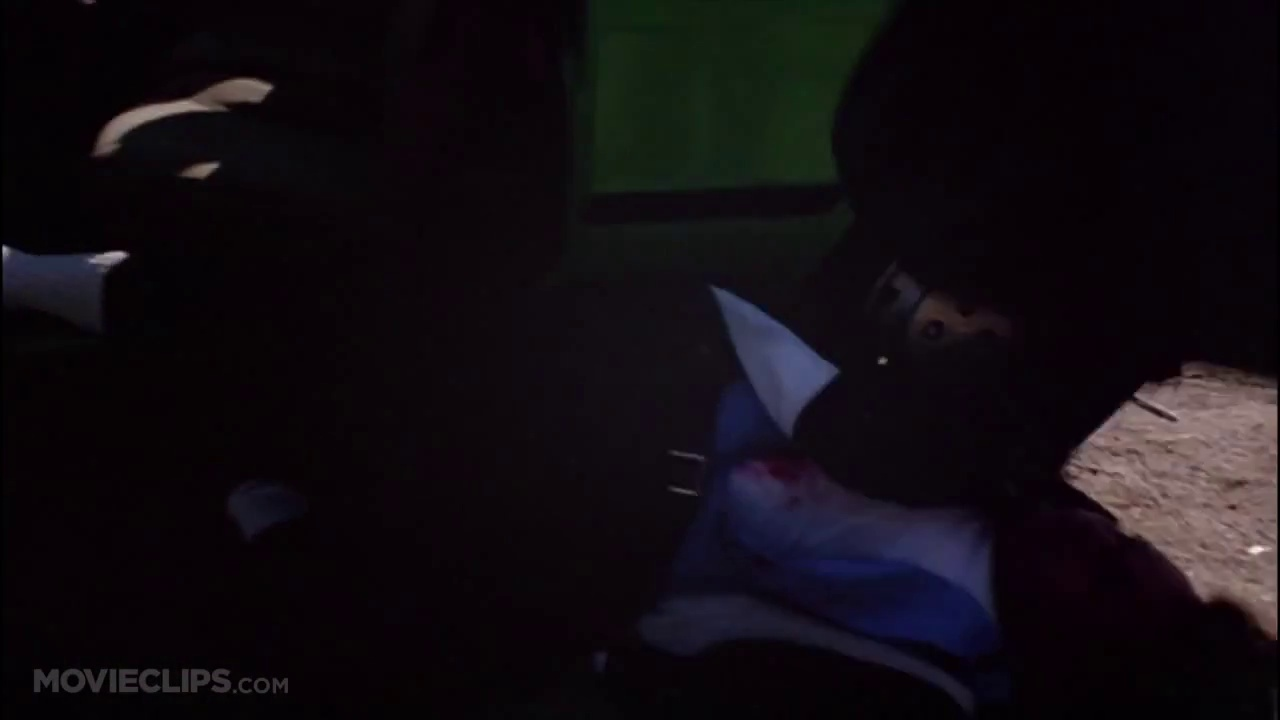

In [5]:
from PIL import Image

Image.open("/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_11_frames_per_vid/v_VYQoxBs5N2A_seg_90_100/frame_01.jpg")

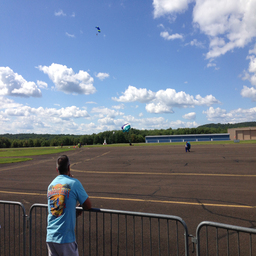

In [3]:
Image.open('../data/of500_images_resized/parachuting_137.jpg')

## Evaluate

In [18]:
from coval.coval.eval import evaluator

In [21]:
evaluator.lea(output, valid_random_GT,)

TypeError: lea() missing 1 required positional argument: 'mention_to_gold'

In [20]:
from evaluate import load
coval = load('coval')

ModuleNotFoundError: No module named 'coval.conll'

In [6]:
import json
valid_random_GT = json.load(open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vidsitu_valid_subset_GT.json', 'r'))
output = json.load(open('vidsitu_output_top1_valid_update.json', 'r'))
#compute_metrics(decoded_labels, decoded_predictions)

In [10]:
evaluate_predictions(output, valid_random_GT)

first 5 GT:  ['man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car']
first 5 Pred:  ['man in a black shirt driving a car', 'car driving down a road', 'desert landscape', 'man in black leather jacket driving a car', 'car driving down a dirt road']


{'rouge': {'rouge1': 0.18649008171197623,
  'rouge2': 0.05280493914911276,
  'rougeL': 0.17993479089514636,
  'rougeLsum': 0.17988681064482237},
 'meteor': {'meteor': 0.18692675253780897},
 'cider': 0.31975610461491033}

In [7]:
from pycocoevalcap.cider.cider import Cider
import evaluate
import numpy as np
metrics = {}
for name in ['rouge', 'meteor']: #bleu
    metrics[name] = evaluate.load(name)
metrics['cider'] = Cider()


[nltk_data] Downloading package wordnet to /home/dhruv/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
from collections import defaultdict

def compute_metrics(decoded_labels, decoded_predictions):
    print("first 5 GT: ", decoded_labels[:5])
    print("first 5 Pred: ", decoded_predictions[:5])
    
    result = defaultdict(dict)
    for key, metric in metrics.items():
        if key in ['rouge', 'bleu', 'meteor']:
            # Compute the metric directly for these cases
            result[key] = metric.compute(predictions=decoded_predictions, references=decoded_labels)
        elif key in ['cider']:
            # Create dictionaries for GT and predictions as required by the CIDEr metric
            gt_dict = {cs: [decoded_labels[cs]] for cs in range(len(decoded_labels))}
            pred_dict = {cs: [decoded_predictions[cs]] for cs in range(len(decoded_predictions))}
            # Compute the CIDEr score
            cider_score = metric.compute_score(gt_dict, pred_dict)
            result[key] = cider_score[0]
    
    return dict(result)

In [9]:
import re
def normalize_role_name(role_name):
    """
    Normalize the 'Arg #' part of the role name by removing spaces.
    """
    return re.sub(r'Arg\s*(\d+)', r'Arg\1', role_name)
    
def is_valid_frame(frame_prediction):
    """
    Check if a frame prediction is valid.
    A frame is considered valid if it has at least one non-empty prediction.
    """
    return any(noun for noun_list in frame_prediction["Args"].values() if noun_list for noun in noun_list)

def evaluate_predictions(output, GT, return_dict=False):
    predictions = []
    ground_truths = []
    index = []
    for vid_seg, events in output.items():
        for event_key, frames in events.items():
            event_gt = None
            for gt_event in GT:
                if gt_event[event_key]["vid_seg_int"] == vid_seg:
                    event_gt = gt_event[event_key]
                    break

            if not event_gt:
                print(f"No GT found for {vid_seg} {event_key}")
                continue
            #print('event_key:',event_key,'vid_seg:',vid_seg)
            valid_frames = []
            for frame in frames:
                for frame_key, frame_prediction in frame.items():
                    if frame_prediction is None:
                        continue
                    #print(frame_prediction['Args'].values())
                    #if all(not noun[0] for noun in frame_prediction["Args"].values()):
                    # if all(noun[0] == '' for noun in frame_prediction["Args"].values()):  # Check if all predicted nouns are empty
                    #     continue
                    if not is_valid_frame(frame_prediction):  # Check if the frame is valid
                        continue
                    valid_frames.append(frame_prediction)

            if not valid_frames:
                continue

            num_valid_frames = len(valid_frames)
            #print('num_frames:',num_valid_frames)
            gt_args = {normalize_role_name(role): gt_noun for role, gt_noun in event_gt["Args"].items()}

            #print(num_valid_frames)
            for frame_prediction in valid_frames:
                for role, predicted_noun in frame_prediction["Args"].items():
                    role = normalize_role_name(role)
                    if role not in gt_args:
                        continue
                    if predicted_noun == []:
                        predicted_noun = ['']
                    index.append(f"{vid_seg}-{event_key}-{frame_key}-{role}")
                    predictions.append(predicted_noun[0])  # Assuming there's only one prediction per role
                    ground_truths.append(event_gt["Args"][role])  # Add corresponding GT value or empty if role not in GT
                #print('len_ground_truths:',len(ground_truths))
    #return ground_truths, predictions
    if return_dict:
        return {'index': index, 'predictions': predictions, 'ground_truths': ground_truths}
    results = compute_metrics(ground_truths, predictions)
    return results

In [72]:
# for frame in output['v_VYQoxBs5N2A_seg_120_130']['Ev1']:
#     for frame_key, frame_prediction in frame.items():
#         for role, predicted_noun in frame_prediction["Args"].items():
#             print(predicted_noun[0])
#         #print(frame_prediction['Args'].values())

valid_frames = []

for frame in output['v_VYQoxBs5N2A_seg_120_130']['Ev1']:
    for frame_key, frame_prediction in frame.items():
        if frame_prediction is None:
            continue
        #if all(not noun[0] for noun in frame_prediction["Args"].values()):
        # if all(noun[0] == '' or noun is None for noun in frame_prediction["Args"].values()):  # Check if all predicted nouns are empty
        #     continue
        if not is_valid_frame(frame_prediction):  # Check if the frame is valid
            continue
        valid_frames.append(frame_prediction)


In [22]:
result_dict = evaluate_predictions(output, valid_random_GT, return_dict=True)

In [80]:
evaluate_predictions(output, valid_random_GT)

first 5 GT:  ['man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car']
first 5 Pred:  ['', 'car', 'lake', 'man in wetsuit', 'car']


{'rouge': {'rouge1': 0.15760702741364205,
  'rouge2': 0.05045525217637996,
  'rougeL': 0.15631259499362407,
  'rougeLsum': 0.156491400053466},
 'meteor': {'meteor': 0.1161154297631468},
 'cider': 0.2784856177307381}

In [23]:
import pandas as pd

df = pd.DataFrame({'index': result_dict['index'], 'ground_truths': result_dict['ground_truths'], 'predictions': result_dict['predictions']})

In [24]:
df 

,index,ground_truths,predictions
0,v_VYQoxBs5N2A_seg_120_130-Ev1-frame_02-Arg0 (d...,man in a black police uniform,man in a black shirt driving a car
1,v_VYQoxBs5N2A_seg_120_130-Ev1-frame_02-Arg1 (v...,car,car driving down a road
2,v_VYQoxBs5N2A_seg_120_130-Ev1-frame_02-Scene o...,down a street,desert landscape
3,v_VYQoxBs5N2A_seg_120_130-Ev2-frame_04-Arg0 (d...,man in a black police uniform,man in black leather jacket driving a car
4,v_VYQoxBs5N2A_seg_120_130-Ev2-frame_04-Arg1 (v...,car,car driving down a dirt road
...,...,...,...
15529,v_S-2cloMm4Lk_seg_95_105-Ev4-frame_08-Arg2 (li...,anyone nearby,the man in the black leather jacket and black hat
15530,v_S-2cloMm4Lk_seg_95_105-Ev4-frame_08-Scene of...,streets,dark alleyway
15531,v_S-2cloMm4Lk_seg_95_105-Ev4-frame_08-Arg0 (sh...,green man,man in a black suit with a red tie and a white...
15532,v_S-2cloMm4Lk_seg_95_105-Ev4-frame_08-Arg2 (li...,anyone nearby,the man in the black suit with a red tie and a...


In [92]:
results = evaluate_predictions(output, valid_random_GT)

ground_truths 38138 predictions 38138
GT:  ['man in a black police uniform', '', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'car', 'down a street', 'man in a black police uniform', 'money', 'car', 'man in a black police uniform', 'money', 'car', 'man in a black police uniform', 'money', 'man in a black police uniform', 'man with blood on shirt', '', '', '', '', '', 'man with blood on shirt', '', '', '', '', '', 'road in the desert', '', '', '', 'road in the desert', 'man in black', 'arm', 'woman in middle of the road', 'road in the desert', 'man in black', 'woman in middle of the road', 'road in the desert', 'man in black', 'woman in middle of the road', 'road in the desert', 'man in black', 'road i

In [93]:
results

{'rouge': {'rouge1': 0.057719090439737414,
  'rouge2': 0.018523549683589886,
  'rougeL': 0.057303573060014795,
  'rougeLsum': 0.057309179623525136},
 'meteor': {'meteor': 0.04254701855729615},
 'cider': 0.10389228069011014}

In [94]:
results['cider']

0.10389228069011014

In [4]:
test = json.load(open('/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_testsrl_noann_lb.json', 'r')) #/home/dhruv/Projects/VidSitu/vidsitu_data/vidsitu_annotations/vseg_ann_files/vsann_testsrl_noann_lb.json

## Video VILA

In [22]:
for i in valid:
    if i['Ev2']['vid_seg_int'] == 'v_VYQoxBs5N2A_seg_120_130':
        print(i)

{'Ev1': {'vid_uid': 'VYQoxBs5N2A1', 'vid_seg_int': 'v_VYQoxBs5N2A_seg_120_130', 'EvRel': 'Causes', 'Args': {'Arg0 (driver)': 'man with badge', 'Arg1 (vehicle or path)': 'car', 'ArgM (direction)': 'forwards', 'ArgM (manner)': 'intently', 'Scene of the Event': 'road'}, 'Arg_List': {'Arg0 (driver)': '0', 'Arg1 (vehicle or path)': '1', 'ArgM (direction)': '2', 'ArgM (manner)': '3', 'Scene of the Event': '4'}, 'Verb': 'drive (drive a vehicle)', 'VerbID': 'drive.01'}, 'Ev2': {'vid_uid': 'VYQoxBs5N2A1', 'vid_seg_int': 'v_VYQoxBs5N2A_seg_120_130', 'EvRel': 'Causes', 'Args': {'Arg0 (driver)': 'man with badge', 'Arg1 (vehicle or path)': 'car', 'ArgM (direction)': 'forwards', 'ArgM (manner)': 'intently', 'Scene of the Event': 'road'}, 'Arg_List': {'Arg0 (driver)': '0', 'Arg1 (vehicle or path)': '1', 'ArgM (direction)': '2', 'ArgM (manner)': '3', 'Scene of the Event': '4'}, 'Verb': 'drive (drive a vehicle)', 'VerbID': 'drive.01'}, 'Ev3': {'vid_uid': 'VYQoxBs5N2A1', 'vid_seg_int': 'v_VYQoxBs5N2A_se

In [ ]:
v_VYQoxBs5N2A_seg_120_130

In [ ]:
["Arg0 (driver)","Arg1 (vehicle or path)","Scene of the Event"]

In [36]:
import subprocess

json_vidsitu_prompt = """
Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the label (noun) filling these roles.
JSON Response Format Template:
{{
  "Verb": "drive (drive a vehicle)",
  "Roles_and_Nouns": {{
    "Arg0 (driver)": [""],
    "Arg1 (vehicle or path)" : [""],
    "Scene of the Event": [""]
  }}
}}

In-Context Examples for Guidance:
<video>
{{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": ["Outdoors"],
    "Target": ["Prey"],
    "Agent": ["Wolf"]
  }}
}}
{{
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": ["Tree"],
    "Substance": ["Water"],
    "Place": ["Forest"],
    "Agent": ["Person"],
    "Source": ["Hose"]
  }}
}}
{{
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "Destination": ["Base"],
    "Place": ["Playing Field"],
    "Agent": ["Player"]
  }}
}}
Now, based on the video <video>, verb drive (drive a vehicle) and roles, fill in the structured summary below and include the label (noun) that fills each role.
"""

video_file = "./v_VYQoxBs5N2A_seg_120_130_Ev2.mp4"

# Prepare the command
command = [
    "python", "-W", "ignore", "./llava/eval/run_vila.py",
    "--model-path", "Efficient-Large-Model/VILA1.5-3b",
    "--conv-mode", "vicuna_v1",
    "--query", json_vidsitu_prompt,
    "--video-file", video_file
]

# Run the command using subprocess
result = subprocess.run(command, capture_output=True, text=True)

# Print the output and error
print("Output:", result.stdout)
print("Error:", result.stderr)

Output: no <image> tag found in input. Automatically append one at the beginning of text.
input:  <image>
<image>
<image>
<image>
<image>
<image>

Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the label (noun) filling these roles.
JSON Response Format Template:
{{
  "Verb": "drive (drive a vehicle)",
  "Roles_and_Nouns": {{
    "Arg0 (driver)": [""],
    "Arg1 (vehicle or path)" : [""],
    "Scene of the Event": [""]
  }}
}}

In-Context Examples for Guidance:
<video>
{{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": ["Outdoors"],
    "Target": ["Prey"],
    "Agent": ["Wolf"]
  }}
}}
{{
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": ["Tree"],
    "Substance": ["Water"],
    "Place": ["Forest"],
    "Agent": ["Person"],
    "Source

In [6]:
"""
Given the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the label (noun) filling these roles.
JSON Response Format Template:
{{
  "Verb": "{verb}",
  "Roles_and_Nouns": {{
    {roles_json}
  }}
}}

In-Context Examples for Guidance:
{{
  "Verb": "Prowling",
  "Roles_and_Nouns": {{
    "Place": ["Outdoors"],
    "Target": ["Prey"],
    "Agent": ["Wolf"]
  }}
}}
{{
  "Verb": "Spraying",
  "Roles_and_Nouns": {{
    "Destination": ["Tree"],
    "Substance": ["Water"],
    "Place": ["Forest"],
    "Agent": ["Person"],
    "Source": ["Hose"]
  }}
}}
{{
  "Verb": "Slipping",
  "Roles_and_Nouns": {{
    "Destination": ["Base"],
    "Place": ["Playing Field"],
    "Agent": ["Player"]
  }}
}}
Now, based on the video <video>, verb {verb} and roles {roles_list}, fill in the structured summary below and include the label (noun) that fills each role.
"""

'\nGiven the image, provide a structured situational summary following the JSON response format template, that captures the essence of the scene. If an action or activity is taking place, describe the action (verb). Then, for each role associated with this verb (action), provide the label (noun) filling these roles.\nJSON Response Format Template:\n{{\n  "Verb": "{verb}",\n  "Roles_and_Nouns": {{\n    {roles_json}\n  }}\n}}\n\nIn-Context Examples for Guidance:\n{{\n  "Verb": "Prowling",\n  "Roles_and_Nouns": {{\n    "Place": ["Outdoors"],\n    "Target": ["Prey"],\n    "Agent": ["Wolf"]\n  }}\n}}\n{{\n  "Verb": "Spraying",\n  "Roles_and_Nouns": {{\n    "Destination": ["Tree"],\n    "Substance": ["Water"],\n    "Place": ["Forest"],\n    "Agent": ["Person"],\n    "Source": ["Hose"]\n  }}\n}}\n{{\n  "Verb": "Slipping",\n  "Roles_and_Nouns": {{\n    "Destination": ["Base"],\n    "Place": ["Playing Field"],\n    "Agent": ["Player"]\n  }}\n}}\nNow, based on the video <video>, verb {verb} and 

In [16]:
from IPython.display import Video

Video("/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_video_trimmed_dir/v_VYQoxBs5N2A_seg_120_130.mp4")

In [8]:
v_VYQoxBs5N2A_seg_120_130

'/home/dhruv/Projects/VidSitu/vidsitu_data/vsitu_video_trimmed_dir'

In [11]:


def trim_video_ffmpeg_python(input_path, output_path, start_time, end_time):
    # Start building the ffmpeg command
    stream = ffmpeg.input(input_path, ss=start_time, to=end_time)
    
    # Set output parameters and output path
    stream = ffmpeg.output(stream, output_path)
    
    # Execute the ffmpeg command
    ffmpeg.run(stream)

# Example usage
input_path = 'ffmpeg-7.0.1-amd64-static/v_VYQoxBs5N2A_seg_120_130_Ev2.mp4'
output_path = 'output.mp4'
start_time = '00:00:00'  # start at 1 minute (HH:MM:SS format)
end_time = '00:00:02'    # end at 1 minute 30 seconds (HH:MM:SS format)

trim_video_ffmpeg_python(input_path, output_path, start_time, end_time)

FileNotFoundError: [Errno 2] No such file or directory: 'ffmpeg'